<a href="https://colab.research.google.com/github/fkvldjtm/LGMRepo/blob/master/MyCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Drive Mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
# Google Drive numpy image 데이터 가져오기

!cp drive/MyDrive/Section4_Project/test_anime_np.npy ./
!cp drive/MyDrive/Section4_Project/test_selfie_np.npy ./
!cp drive/MyDrive/Section4_Project/train_anime_np.npy ./
!cp drive/MyDrive/Section4_Project/train_selfie_np.npy ./

In [4]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [1]:
import os, random
import PIL
import pathlib
import numpy as np
from PIL import ImageDraw
from struct import unpack
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.layers import Flatten
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from IPython import display

autotune = tf.data.experimental.AUTOTUNE

In [2]:
train_selfie = np.load('./train_selfie_np.npy')
train_anime = np.load('./train_anime_np.npy')
test_selfie = np.load('./test_selfie_np.npy')
test_anime = np.load('./test_anime_np.npy')

(256, 256, 3)


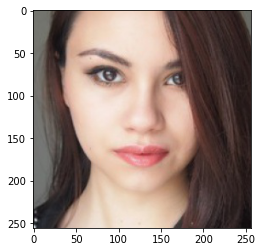

In [3]:
s_img = train_selfie[0]
print(s_img.shape)
plt.imshow(s_img.astype(np.uint8))
plt.show()

In [3]:
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)

def augmentation(image, augment_size):
    seed = random.randint(0, 2 ** 31 - 1)
    ori_image_shape = tf.shape(image)
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.resize_images(image, [augment_size, augment_size])
    image = tf.random_crop(image, ori_image_shape, seed=seed)
    return image

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, augment_flag=False):
    
    # Resize to the original size first
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    
    if augment_flag:
      augment_size = input_img_size[0] + 30
      p = random.random()
      if p > 0.5:
        img = augmentation(img, augment_size)

    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [4]:

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Weights regularizer for the layers.
weight_regularizer = tf.keras.regularizers.L2(0.0001)

batch_size = 1

# Apply the preprocessing operations to the training data
train_selfie_ds = (
    tf.data.Dataset.from_tensor_slices(train_selfie).map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(len(train_selfie))
    .batch(batch_size)
)

train_anime_ds = (
    tf.data.Dataset.from_tensor_slices(train_anime).map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(len(train_anime))
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_selfie_ds = (
    tf.data.Dataset.from_tensor_slices(test_selfie).map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(len(test_selfie))
    .batch(batch_size)
)

test_anime_ds = (
    tf.data.Dataset.from_tensor_slices(test_anime).map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(len(test_anime))
    .batch(batch_size)
)

In [5]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [6]:
def adaptive_instance_layer_norm(x, gamma, beta, smoothing=True) :
    ch = x.shape[-1]
    eps = 1e-5

    ins_mean, ins_sigma = tf.nn.moments(x, axes=[1, 2], keep_dims=True)
    x_ins = (x - ins_mean) / (tf.sqrt(ins_sigma + eps))

    ln_mean, ln_sigma = tf.nn.moments(x, axes=[1, 2, 3], keep_dims=True)
    x_ln = (x - ln_mean) / (tf.sqrt(ln_sigma + eps))

    rho = tf.get_variable("rho", [ch], initializer=tf.constant_initializer(1.0), constraint=lambda x: tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0))

    if smoothing :
        rho = tf.clip_by_value(rho - tf.constant(0.1), 0.0, 1.0)

    x_hat = rho * x_ins + (1 - rho) * x_ln


    x_hat = x_hat * gamma + beta

    return x_hat

In [7]:
def residual_block(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), padding="valid", gamma_initializer=gamma_init, use_bias=True):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, kernel_regularizer=weight_regularizer, padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(center=True, scale=True, gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(dim,kernel_size,strides=strides, kernel_initializer=kernel_initializer, kernel_regularizer=weight_regularizer, padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(center=True, scale=True, gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def adaptive_ins_layer_resblock(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), padding="valid", gamma=1, beta=0, use_bias=True, smoothing=True):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, kernel_regularizer=weight_regularizer, padding=padding, use_bias=use_bias)(x)
    x = adaptive_instance_layer_norm(x, gamma, beta, smoothing)
    x = activation(x)

    x = ReflectionPadding2D()(x)   
    x = layers.Conv2D(kernel_size, strides=strides, kernel_initializer=kernel_initializer, kernel_regularizer=weight_regularizer, padding=padding, use_bias=use_bias)(x)
    x = adaptive_instance_layer_norm(x, gamma, beta, smoothing)
    x = layers.add([input_tensor, x])
    return x

In [8]:
def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(2, 2), padding="same", gamma_initializer=gamma_init, use_bias=True):
    x = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, kernel_regularizer=weight_regularizer, padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init, gamma_initializer=gamma_init, use_bias=True):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=weight_regularizer, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [9]:
def MLP(x, activation, channel, use_bias=True):

    # for i in range(2) :
    #     x = fully_connected(x, channel, use_bias, scope='linear_' + str(i))
    #     x = relu(x)

    for i in range(2):
      x = layers.Dense(units=channel, kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=use_bias)(x)
      x = activation(x)

    x = Flatten()(x)
    gamma = layers.Dense(units=channel, kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=use_bias)(x)
    beta = layers.Dense(units=channel, kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=use_bias)(x)

    gamma = tf.reshape(gamma, shape=[batch_size, 1, 1, channel])
    beta = tf.reshape(beta, shape=[batch_size, 1, 1, channel])

    return gamma, beta

In [10]:
def get_cam_weight(x):
    # x = Flatten()(x)
    # class_layer = layers.Dense(2, activation='softmax')
    # class_out = class_layer(x)
    # w = class_layer.get_weights()[0]

    # x = tf.matmul(x,w)

    # weights = tf.gather(tf.transpose(w),0)

    x = Flatten()(x)
    shape = x.get_shape().as_list()
    channel = shape[-1]

    class_layer = layers.Dense(units=channel, kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=True)
    class_out = class_layer(x)
    w = class_layer.get_weights()[0]
    x = tf.matmul(x, w)
    weights = tf.gather(tf.transpose(w),0)

    return x, weights

In [11]:
def get_generator(filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
  ):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=True)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Class Activation Map
    cam_x = layers.GlobalAveragePooling2D()(x)
    cam_gap_logit, cam_x_weight = get_cam_weight(cam_x)
    x_gap = tf.multiply(x,cam_x_weight)

    cam_x = layers.GlobalMaxPooling2D()(x)
    cam_gmp_logit, cam_x_weight = get_cam_weight(cam_x)
    x_gmp = tf.multiply(x,cam_x_weight)

    cam_logit = tf.concat([cam_gap_logit, cam_gmp_logit], axis=-1)
    x = tf.concat([x_gap, x_gmp], axis=-1)
    x = layers.Conv2D(filters, (1, 1), kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=True)(x)
    x = layers.Activation("relu")(x)

    # heatmap = tf.squeeze(tf.reduce_sum(x, axis=-1)) # dimension 1 제거

    # Gamma, Beta block
    # gamma, beta = MLP(x, activation=layers.Activation("relu"), channel=filters*num_residual_blocks )

    # # Residual blocks
    # for _ in range(num_residual_blocks):
    #   x =  adaptive_ins_layer_resblock(x, activation=layers.Activation("relu"), kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), padding="valid", gamma=gamma, beta=beta, use_bias=True, smoothing=True)
 
    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))
 
    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)
  
    model = keras.models.Model(inputs=img_input, outputs=[x, cam_logit], name=name)
    #model = keras.models.Model(inputs=img_input, outputs=[x], name=name)

    return model  

In [12]:
def get_discriminator(
    filters=64, 
    kernel_initializer=kernel_init, 
    num_downsampling=3, 
    name=None
    ):

    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2))
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1))

    num_filters *= 2
    x = layers.Conv2D(num_filters, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)
    x = layers.LeakyReLU(0.2)(x)

    # Class Activation Map
    cam_x = layers.GlobalAveragePooling2D()(x)
    cam_gap_logit, cam_x_weight = get_cam_weight(cam_x)
    x_gap = tf.multiply(x,cam_x_weight)

    cam_x = layers.GlobalMaxPooling2D()(x)
    cam_gmp_logit, cam_x_weight = get_cam_weight(cam_x)
    x_gmp = tf.multiply(x,cam_x_weight)

    cam_logit = tf.concat([cam_gap_logit, cam_gmp_logit], axis=-1)
    x = tf.concat([x_gap, x_gmp], axis=-1)
    x = layers.Conv2D(filters, (1, 1), kernel_initializer=kernel_init, kernel_regularizer=weight_regularizer, use_bias=True)(x)
    x = layers.Activation("relu")(x)

    heatmap = tf.squeeze(tf.reduce_sum(x, axis=-1)) # dimension 1 제거

    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=img_input, outputs=[x, cam_logit], name=name)
    
    return model

In [13]:
# Get the generators
gen_G = get_generator(name="generator_G")
gen_F = get_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [16]:
# gen_G.summary()

In [31]:
# ! rm -rf ./training_checkpoints/*

In [14]:
gen_G_optima = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
gen_F_optima = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
disc_X_optima = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
disc_Y_optima = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
ckpt = tf.train.Checkpoint(generator_g=gen_G,
                            generator_f=gen_F,
                            discriminator_x=disc_X,
                            discriminator_y=disc_Y,
                            generator_g_optimizer=gen_G_optima,
                            generator_f_optimizer=gen_F_optima,
                            discriminator_x_optimizer=disc_X_optima,
                            discriminator_y_optimizer=disc_Y_optima)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_prefix, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cam_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cam_loss_fn = cam_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y, cam_xy = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x, cam_yx = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x, cam_xyx = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y, cam_yxy = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x, cam_xx = self.gen_F(real_x, training=True)
            same_y, cam_yy = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x, real_x_cam = self.disc_X(real_x, training=True)
            disc_fake_x, fake_x_cam = self.disc_X(fake_x, training=True)

            disc_real_y, real_y_cam = self.disc_Y(real_y, training=True)
            disc_fake_y, fake_y_cam = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y) + self.generator_loss_fn(fake_y_cam)
            gen_F_loss = self.generator_loss_fn(disc_fake_x) + self.generator_loss_fn(fake_x_cam)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Cam loss
            cam_loss_G = self.cam_loss_fn(source=cam_yx, non_source=cam_xx)
            cam_loss_F = self.cam_loss_fn(source=cam_xy, non_source=cam_yy)

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G + cam_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F + cam_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x) + self.discriminator_loss_fn(real_x_cam, fake_x_cam)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y) + self.discriminator_loss_fn(real_y_cam, fake_y_cam)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )
        
        
        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [17]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=5):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
        display.clear_output(wait=True)
        
        fig, ax = plt.subplots(5, 2, figsize=(10, 15))
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.5, top=0.9, wspace=0.2, hspace=0.2)
        
        for i, img in enumerate(test_selfie_ds.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            #print("predict :",prediction[0].shape)
            prediction = prediction[0]
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save("generated_img/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1))
        plt.show()
        plt.close()

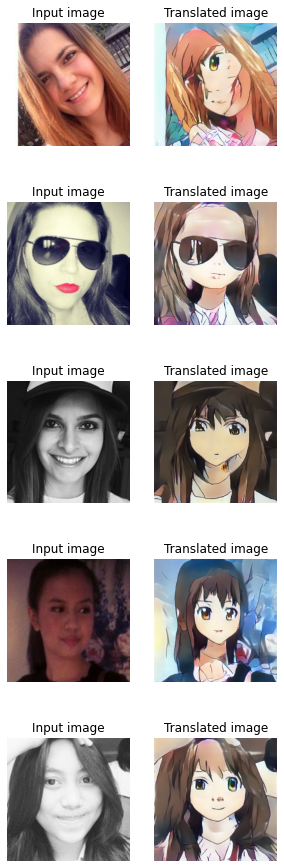

100/100 [==============================] - 54s 542ms/step - G_loss: 4.1109 - F_loss: 4.3362 - D_X_loss: 0.4827 - D_Y_loss: 0.4566


In [18]:
# checkpoint restore
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    # fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    # fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake), logits=fake))
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5
    # real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real), logits=real))
    # fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake), logits=fake))
    # return (real_loss + fake_loss)

def cam_loss_fn(source, non_source):
    # id_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(source), logits=source))
    # non_id_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(non_source), logits=non_source))
    # return (id_loss + non_id_loss)
    id_loss = adv_loss_fn(tf.ones_like(source), source)
    non_id_loss = adv_loss_fn(tf.zeros_like(non_source), non_source)
    return (id_loss + non_id_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=gen_G_optima,
    gen_F_optimizer=gen_F_optima,
    disc_X_optimizer=disc_X_optima,
    disc_Y_optimizer=disc_Y_optima,
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
    cam_loss_fn = cam_loss_fn,
)

# Callbacks
plotter = GANMonitor()

# Train the model for just one epoch only using 100 images
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_selfie_ds.take(100), train_anime_ds.take(100))), # for 100 samples
    epochs=100,
    callbacks=plotter,
)

In [23]:
for i, img in enumerate(train_selfie_ds.take(3400)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    original = keras.preprocessing.image.array_to_img(img)
    original.save("result_train_img/selfie2anime/predicted_img_G_A_{}.png".format(i))
    prediction = keras.preprocessing.image.array_to_img(prediction[0])
    prediction.save("result_train_img/selfie2anime/predicted_img_F_A_{}.png".format(i))

for i, img in enumerate(train_anime_ds.take(3400)):
    prediction = cycle_gan_model.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    original = keras.preprocessing.image.array_to_img(img)
    original.save("result_train_img/anime2selfie/predicted_img_G_B_{}.png".format(i))
    prediction = keras.preprocessing.image.array_to_img(prediction[0])
    prediction.save("result_train_img/anime2selfie/predicted_img_F_B_{}.png".format(i))

In [24]:
!zip -r /content/result_Remygan_train_img.zip /content/result_train_img/
!cp -rf result_Remygan_train_img.zip drive/MyDrive/Section4_Project/MyGAN/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/result_train_img/selfie2anime/predicted_img_G_A_2107.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_F_A_2008.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_F_A_3168.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_F_A_2650.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_G_A_2684.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_G_A_1122.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_G_A_2819.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_F_A_52.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_G_A_2302.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_F_A_3362.png (deflated 0%)
  adding: content/result_train_img/selfie2anime/predicted_img_G_A_412.png (d

In [38]:
# !zip -r /content/generate_img_01.zip /content/generated_img/

In [19]:
for i, img in enumerate(test_selfie_ds.take(100)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    original = keras.preprocessing.image.array_to_img(img)
    original.save("result_save/selfie2anime/predicted_img_G_A_{}.png".format(i))
    prediction = keras.preprocessing.image.array_to_img(prediction[0])
    prediction.save("result_save/selfie2anime/predicted_img_F_A_{}.png".format(i))

for i, img in enumerate(test_anime_ds.take(100)):
    prediction = cycle_gan_model.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    original = keras.preprocessing.image.array_to_img(img)
    original.save("result_save/anime2selfie/predicted_img_G_B_{}.png".format(i))
    prediction = keras.preprocessing.image.array_to_img(prediction[0])
    prediction.save("result_save/anime2selfie/predicted_img_F_B_{}.png".format(i))

In [20]:
!zip -r /content/RemyGAN_checkpoint_400.zip /content/training_checkpoints/
!cp -rf RemyGAN_checkpoint_400.zip drive/MyDrive/Section4_Project/MyGAN/

  adding: content/training_checkpoints/ (stored 0%)
  adding: content/training_checkpoints/ckpt/ (stored 0%)
  adding: content/training_checkpoints/ckpt/ckpt-401.data-00000-of-00001 (deflated 9%)
  adding: content/training_checkpoints/ckpt/ckpt-402.data-00000-of-00001 (deflated 9%)
  adding: content/training_checkpoints/ckpt/ckpt-404.data-00000-of-00001 (deflated 9%)
  adding: content/training_checkpoints/ckpt/checkpoint (deflated 72%)
  adding: content/training_checkpoints/ckpt/ckpt-403.index (deflated 82%)
  adding: content/training_checkpoints/ckpt/ckpt-402.index (deflated 82%)
  adding: content/training_checkpoints/ckpt/ckpt-405.index (deflated 82%)
  adding: content/training_checkpoints/ckpt/ckpt-401.index (deflated 82%)
  adding: content/training_checkpoints/ckpt/ckpt-404.index (deflated 82%)
  adding: content/training_checkpoints/ckpt/ckpt-405.data-00000-of-00001 (deflated 9%)
  adding: content/training_checkpoints/ckpt/ckpt-403.data-00000-of-00001 (deflated 9%)


In [21]:
!zip -r /content/RemyGAN_result_save_400.zip /content/result_save/
!cp -rf RemyGAN_result_save_400.zip drive/MyDrive/Section4_Project/MyGAN/

  adding: content/result_save/ (stored 0%)
  adding: content/result_save/.ipynb_checkpoints/ (stored 0%)
  adding: content/result_save/anime2selfie/ (stored 0%)
  adding: content/result_save/anime2selfie/predicted_img_F_B_39.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_F_B_9.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_G_B_79.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_G_B_98.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_F_B_78.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_F_B_37.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_F_B_96.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_G_B_42.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_G_B_18.png (deflated 0%)
  adding: content/result_save/anime2selfie/predicted_img_F_B_28.png (deflated 0%)
  adding: content/re